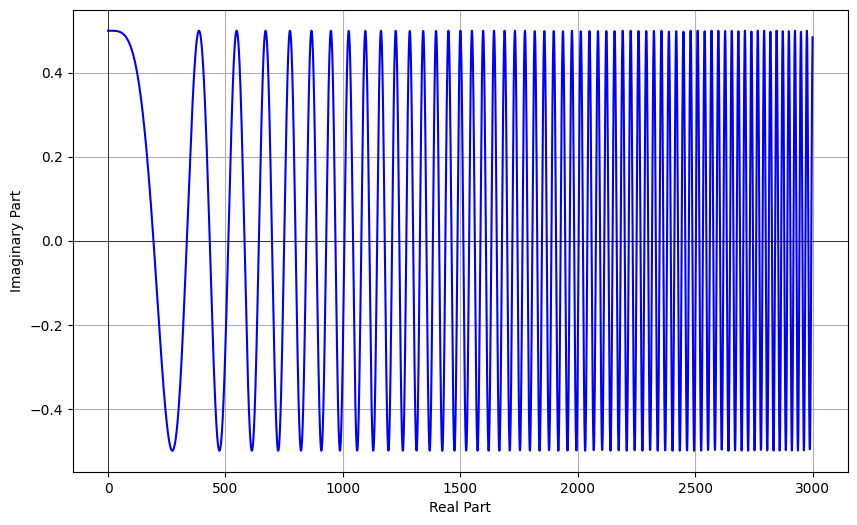

In [36]:

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Read the CSV file into a DataFrame
df = pd.read_csv('sweep.csv')

# Extract real and imaginary parts
real = df['Real']
imaginary = df['Imaginary']

# Create a plot
plt.figure(figsize=(10, 6))
plt.plot(real, linestyle='-', color='b')
plt.xlabel('Real Part')
plt.ylabel('Imaginary Part')
plt.grid(True)
plt.axhline(0, color='black',linewidth=0.5)
plt.axvline(0, color='black',linewidth=0.5)
plt.show()


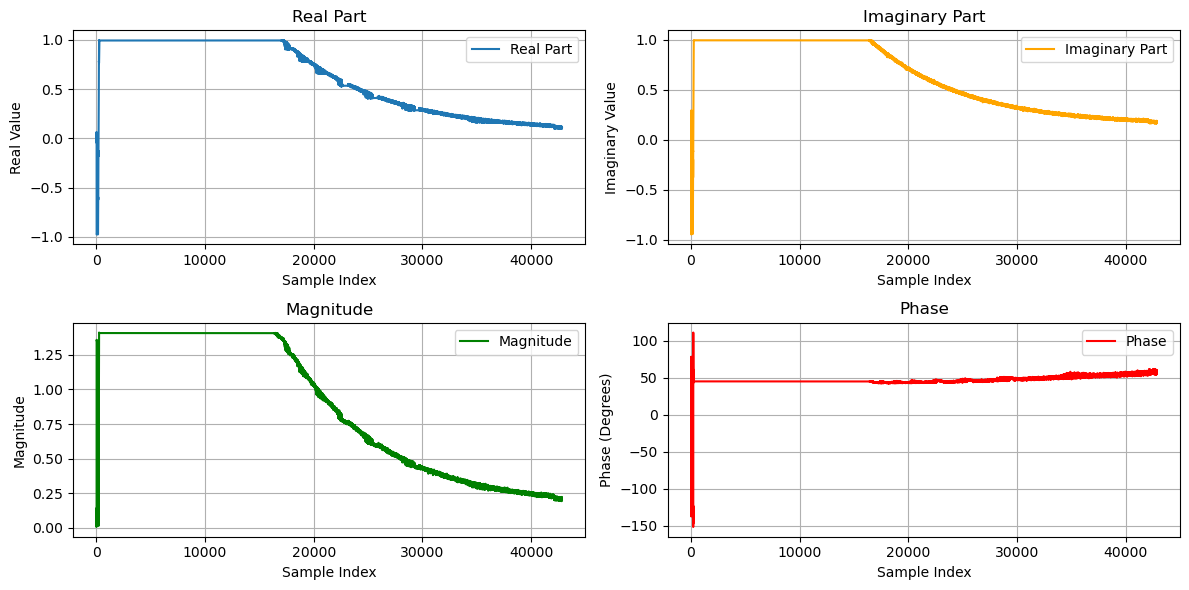

42834


In [90]:
import numpy as np
import matplotlib.pyplot as plt

# Define the path to your binary file
file_path = 'rx_test.bin'


# Read the binary file
with open(file_path, 'rb') as file:
    # Read the data into a numpy array
    # The dtype should match the type of data in the file (double = float64)
    data = np.fromfile(file, dtype=np.float64)

# Reshape or process the data if needed
# Here we assume data was written as 2 doubles per sample
num_new_samples = int(len(data)/2)
data = data.reshape((num_new_samples, 2))


# Create complex numbers from the real and imaginary parts
complex_data = data[:, 0] + 1j * data[:, 1]

# Compute magnitude and phase
magnitudes = np.abs(complex_data)
phases = np.angle(complex_data, deg=True)  # Phase in degrees

# Plotting
fig, axs = plt.subplots(2, 2, figsize=(12, 6))

# Plot real part
axs[0, 0].plot(np.real(complex_data), label='Real Part')
axs[0, 0].set_title('Real Part')
axs[0, 0].set_xlabel('Sample Index')
axs[0, 0].set_ylabel('Real Value')
axs[0, 0].legend()
axs[0, 0].grid(True)

# Plot imaginary part
axs[0, 1].plot(np.imag(complex_data), label='Imaginary Part', color='orange')
axs[0, 1].set_title('Imaginary Part')
axs[0, 1].set_xlabel('Sample Index')
axs[0, 1].set_ylabel('Imaginary Value')
axs[0, 1].legend()
axs[0, 1].grid(True)

# Plot magnitude
axs[1, 0].plot(magnitudes, label='Magnitude', color='green')
axs[1, 0].set_title('Magnitude')
axs[1, 0].set_xlabel('Sample Index')
axs[1, 0].set_ylabel('Magnitude')
axs[1, 0].legend()
axs[1, 0].grid(True)

# Plot phase
axs[1, 1].plot(phases, label='Phase', color='red')
axs[1, 1].set_title('Phase')
axs[1, 1].set_xlabel('Sample Index')
axs[1, 1].set_ylabel('Phase (Degrees)')
axs[1, 1].legend()
axs[1, 1].grid(True)

# Adjust layout
plt.tight_layout()
plt.show()

print(num_new_samples)